### UNet Based end to end segmentation network

In [12]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

##### UNet Architecture

In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features_start=32):
        super(UNet, self).__init__()
        
        # Starting with 128x128 input
        # After 4 max pools of stride 2: 128 -> 64 -> 32 -> 16 -> 8
        
        # Encoder (Downsampling)
        self.encoder1 = DoubleConv(in_channels, features_start)  # 128 -> 128
        self.pool1 = nn.MaxPool2d(2)  # 128 -> 64
        self.encoder2 = DoubleConv(features_start, features_start*2)  # 64 -> 64
        self.pool2 = nn.MaxPool2d(2)  # 64 -> 32
        self.encoder3 = DoubleConv(features_start*2, features_start*4)  # 32 -> 32
        self.pool3 = nn.MaxPool2d(2)  # 32 -> 16
        self.encoder4 = DoubleConv(features_start*4, features_start*8)  # 16 -> 16
        self.pool4 = nn.MaxPool2d(2)  # 16 -> 8
        
        # Bottom
        self.bottom = DoubleConv(features_start*8, features_start*16)  # 8 -> 8
        
        # Decoder (Upsampling)
        self.upconv4 = nn.ConvTranspose2d(features_start*16, features_start*8, kernel_size=2, stride=2)  # 8 -> 16
        self.decoder4 = DoubleConv(features_start*16, features_start*8)  # 16 -> 16
        self.upconv3 = nn.ConvTranspose2d(features_start*8, features_start*4, kernel_size=2, stride=2)  # 16 -> 32
        self.decoder3 = DoubleConv(features_start*8, features_start*4)  # 32 -> 32
        self.upconv2 = nn.ConvTranspose2d(features_start*4, features_start*2, kernel_size=2, stride=2)  # 32 -> 64
        self.decoder2 = DoubleConv(features_start*4, features_start*2)  # 64 -> 64
        self.upconv1 = nn.ConvTranspose2d(features_start*2, features_start, kernel_size=2, stride=2)  # 64 -> 128
        self.decoder1 = DoubleConv(features_start*2, features_start)  # 128 -> 128
        
        # Final Convolution
        self.final_conv = nn.Conv2d(features_start, out_channels, kernel_size=1)  # 128 -> 128

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)  # 128
        enc2 = self.encoder2(self.pool1(enc1))  # 64
        enc3 = self.encoder3(self.pool2(enc2))  # 32
        enc4 = self.encoder4(self.pool3(enc3))  # 16
        
        # Bottom
        bottom = self.bottom(self.pool4(enc4))  # 8
        
        # Decoder with skip connections
        dec4 = self.upconv4(bottom)  # 16
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)  # 32
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)  # 64
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)  # 128
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.decoder1(dec1)
        
        return self.final_conv(dec1)

##### Dataset

In [4]:
class SegmentationDataset(Dataset):
    def __init__(self, color_dir, label_dir):
        self.color_dir = color_dir
        self.label_dir = label_dir
        
        # Define separate transforms for images and labels - no resize needed
        self.image_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.label_transform = transforms.Compose([
            transforms.ToTensor()
        ])
        
        # Get list of image files from color directory
        self.color_images = [f for f in os.listdir(color_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        
        # Create mapping between color and label files
        self.valid_pairs = []
        for color_img in self.color_images:
            base_name = os.path.splitext(color_img)[0]
            
            # Try different possible label extensions
            possible_label_names = [f"{base_name}.png", f"{base_name}.jpg", f"{base_name}.jpeg"]
            
            # Check recursively in label directory
            label_path = None
            for root, _, files in os.walk(label_dir):
                for possible_name in possible_label_names:
                    if possible_name in files:
                        label_path = os.path.join(root, possible_name)
                        relative_path = os.path.relpath(label_path, label_dir)
                        self.valid_pairs.append((color_img, relative_path))
                        break
                if label_path:
                    break
            
            if not label_path:
                print(f"Warning: No matching label found for {color_img}")
        
        print(f"Found {len(self.valid_pairs)} valid image pairs")
        if len(self.valid_pairs) == 0:
            raise RuntimeError("No valid image pairs found!")

    def __len__(self):
        return len(self.valid_pairs)

    def __getitem__(self, idx):
        color_name, label_name = self.valid_pairs[idx]
        
        try:
            # Load color image
            color_path = os.path.join(self.color_dir, color_name)
            image = Image.open(color_path).convert('RGB')
            
            # Verify image size
            if image.size != (128, 128):
                print(f"Warning: Image {color_name} has size {image.size}, expected (128, 128)")
            
            # Load label image
            label_path = os.path.join(self.label_dir, label_name)
            label = Image.open(label_path).convert('L')  # Convert to grayscale
            
            # Verify label size
            if label.size != (128, 128):
                print(f"Warning: Label {label_name} has size {label.size}, expected (128, 128)")
            
            # Convert label to binary tensor
            label = np.array(label)
            label_binary = (label > 0).astype(np.float32)
            label = Image.fromarray((label_binary * 255).astype(np.uint8))
            
            # Apply separate transforms for image and label
            image = self.image_transform(image)
            label = self.label_transform(label)
            
            return image, label
            
        except Exception as e:
            print(f"Error loading image pair ({color_name}, {label_name}): {str(e)}")
            # Return the previous valid pair or the next one
            return self.__getitem__((idx + 1) % len(self.valid_pairs))

##### Training Function

In [5]:
def train_unet(train_dataset, val_dataset, epochs=50, batch_size=8, learning_rate=1e-4):
    # Set up device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Create data loaders with error handling
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0)

    # Initialize model, loss, and optimizer
    model = UNet().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        batch_count = 0
        
        try:
            for batch_idx, (images, masks) in enumerate(train_loader):
                try:
                    images, masks = images.to(device), masks.to(device)
                    
                    # Zero the parameter gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                    
                    # Backward pass and optimize
                    loss.backward()
                    optimizer.step()
                    
                    train_loss += loss.item()
                    batch_count += 1
                    
                    if batch_idx % 10 == 0:
                        print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{len(train_loader)}], '
                              f'Loss: {loss.item():.4f}')
                
                except Exception as e:
                    print(f"Error in batch {batch_idx}: {str(e)}")
                    continue
            
            # Validation
            model.eval()
            val_loss = 0.0
            val_batch_count = 0
            
            with torch.no_grad():
                for images, masks in val_loader:
                    try:
                        images, masks = images.to(device), masks.to(device)
                        outputs = model(images)
                        loss = criterion(outputs, masks)
                        val_loss += loss.item()
                        val_batch_count += 1
                    except Exception as e:
                        print(f"Error in validation: {str(e)}")
                        continue
            
            # Calculate average losses
            avg_train_loss = train_loss / max(batch_count, 1)
            avg_val_loss = val_loss / max(val_batch_count, 1)
            
            print(f'Epoch [{epoch+1}/{epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, '
                  f'Val Loss: {avg_val_loss:.4f}')
            
            # Save best model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': avg_train_loss,
                    'val_loss': best_val_loss,
                }, 'best_unet_model.pth')
        
        except Exception as e:
            print(f"Error in epoch {epoch+1}: {str(e)}")
            continue
    
    print("Training completed. Best model saved.")
    return model

##### Evaluation Function

In [6]:
def evaluate_model(model, test_dir, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create test dataset
    test_dataset = SegmentationDataset(
        os.path.join(test_dir, 'color'), 
        os.path.join(test_dir, 'label'), 
        transform=transform
    )
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Evaluation mode
    model.eval()
    total_loss = 0.0
    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f'Test Loss: {avg_loss:.4f}')
    return avg_loss

##### Visualisation Function

In [7]:
def visualize_sample(dataset, index=0):
    import matplotlib.pyplot as plt
    
    # Get the original dataset before splitting
    if hasattr(dataset, 'dataset'):
        original_dataset = dataset.dataset
        original_index = dataset.indices[index]
    else:
        original_dataset = dataset
        original_index = index
    
    image, label = original_dataset[original_index]
    
    # Convert tensors to numpy for visualization
    image = image.permute(1, 2, 0).numpy()
    label = label.squeeze().numpy()
    
    # Denormalize image (reverse the normalization)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = (image * std) + mean
    image = np.clip(image, 0, 1)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    ax2.imshow(label, cmap='gray')
    ax2.set_title('Binary Label')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

##### Run Everything

In [10]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Set up paths
train_val_dir = r'D:\Emma\cv-project\Dataset\consistent_size\TrainVal'
color_dir = os.path.join(train_val_dir, 'color')
label_dir = os.path.join(train_val_dir, 'label')

# Create full dataset
full_dataset = SegmentationDataset(color_dir, label_dir)

# Split dataset into train and validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Print dataset sizes
print(f"Total dataset size: {len(full_dataset)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Test loading a few samples to verify shapes
print("\nTesting sample loading:")
for i in range(3):
    image, label = full_dataset[i]
    print(f"Sample {i}:")
    print(f"Image shape: {image.shape}")  # Should be [3, 128, 128]
    print(f"Label shape: {label.shape}")  # Should be [1, 128, 128]
    print(f"Image value range: ({image.min():.2f}, {image.max():.2f})")
    print(f"Label value range: ({label.min():.2f}, {label.max():.2f})")
    print()

# train
model = train_unet(train_dataset, val_dataset, epochs=20, batch_size=16)

Found 3680 valid image pairs
Total dataset size: 3680
Training set size: 2944
Validation set size: 736

Testing sample loading:
Sample 0:
Image shape: torch.Size([3, 128, 128])
Label shape: torch.Size([1, 128, 128])
Image value range: (-2.12, 1.96)
Label value range: (0.00, 1.00)

Sample 1:
Image shape: torch.Size([3, 128, 128])
Label shape: torch.Size([1, 128, 128])
Image value range: (-2.12, 2.04)
Label value range: (0.00, 1.00)

Sample 2:
Image shape: torch.Size([3, 128, 128])
Label shape: torch.Size([1, 128, 128])
Image value range: (-2.04, 2.16)
Label value range: (0.00, 1.00)

Using device: cuda
Epoch [1/20], Batch [0/184], Loss: 0.7203
Epoch [1/20], Batch [10/184], Loss: 0.6667
Epoch [1/20], Batch [20/184], Loss: 0.5926
Epoch [1/20], Batch [30/184], Loss: 0.5588
Epoch [1/20], Batch [40/184], Loss: 0.5069
Epoch [1/20], Batch [50/184], Loss: 0.4478
Epoch [1/20], Batch [60/184], Loss: 0.4918
Epoch [1/20], Batch [70/184], Loss: 0.4704
Epoch [1/20], Batch [80/184], Loss: 0.4928
Epoch

In [11]:
def load_best_model(model_path='best_unet_model.pth', device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Initialize a new model
    model = UNet().to(device)
    
    # Load the saved state
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"Loaded model from epoch {checkpoint['epoch']+1}")
    print(f"Training loss: {checkpoint['train_loss']:.4f}")
    print(f"Validation loss: {checkpoint['val_loss']:.4f}")
    
    return model

def visualize_predictions(model, dataset, num_samples=5, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    with torch.no_grad():
        for idx in range(num_samples):
            # Get a sample
            image, true_mask = dataset[idx]
            
            # Make prediction
            input_tensor = image.unsqueeze(0).to(device)
            output = model(input_tensor)
            pred_mask = torch.sigmoid(output).squeeze().cpu()
            
            # Convert image tensor to numpy for visualization
            image = image.permute(1, 2, 0).numpy()
            
            # Denormalize image
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = std * image + mean
            image = np.clip(image, 0, 1)
            
            # Convert masks to numpy
            true_mask = true_mask.squeeze().numpy()
            pred_mask = (pred_mask > 0.5).float().numpy()
            
            # Plot
            axes[idx, 0].imshow(image)
            axes[idx, 0].set_title('Original Image')
            axes[idx, 0].axis('off')
            
            axes[idx, 1].imshow(true_mask, cmap='gray')
            axes[idx, 1].set_title('True Mask')
            axes[idx, 1].axis('off')
            
            axes[idx, 2].imshow(pred_mask, cmap='gray')
            axes[idx, 2].set_title('Predicted Mask')
            axes[idx, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

def calculate_metrics(model, dataset, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.eval()
    iou_scores = []
    dice_scores = []
    
    with torch.no_grad():
        for idx in range(len(dataset)):
            image, true_mask = dataset[idx]
            
            # Make prediction
            input_tensor = image.unsqueeze(0).to(device)
            output = model(input_tensor)
            pred_mask = (torch.sigmoid(output) > 0.5).float().squeeze().cpu()
            true_mask = true_mask.squeeze()
            
            # Calculate IoU
            intersection = (pred_mask * true_mask).sum()
            union = pred_mask.sum() + true_mask.sum() - intersection
            iou = (intersection + 1e-6) / (union + 1e-6)
            iou_scores.append(iou.item())
            
            # Calculate Dice coefficient
            dice = (2 * intersection + 1e-6) / (pred_mask.sum() + true_mask.sum() + 1e-6)
            dice_scores.append(dice.item())
    
    # Calculate average metrics
    avg_iou = np.mean(iou_scores)
    avg_dice = np.mean(dice_scores)
    
    print(f"Average IoU: {avg_iou:.4f}")
    print(f"Average Dice Coefficient: {avg_dice:.4f}")
    
    return avg_iou, avg_dice

C:\Users\dcb_r\AppData\Local\Temp\ipykernel_11128\1710009101.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Loaded model from epoch 10
Training loss: 0.1742
Validation loss: 0.2703
Found 3710 valid image pairs

Calculating metrics on test dataset:
Average IoU: 0.8230
Average Dice Coefficient: 0.8952

Visualizing predictions:


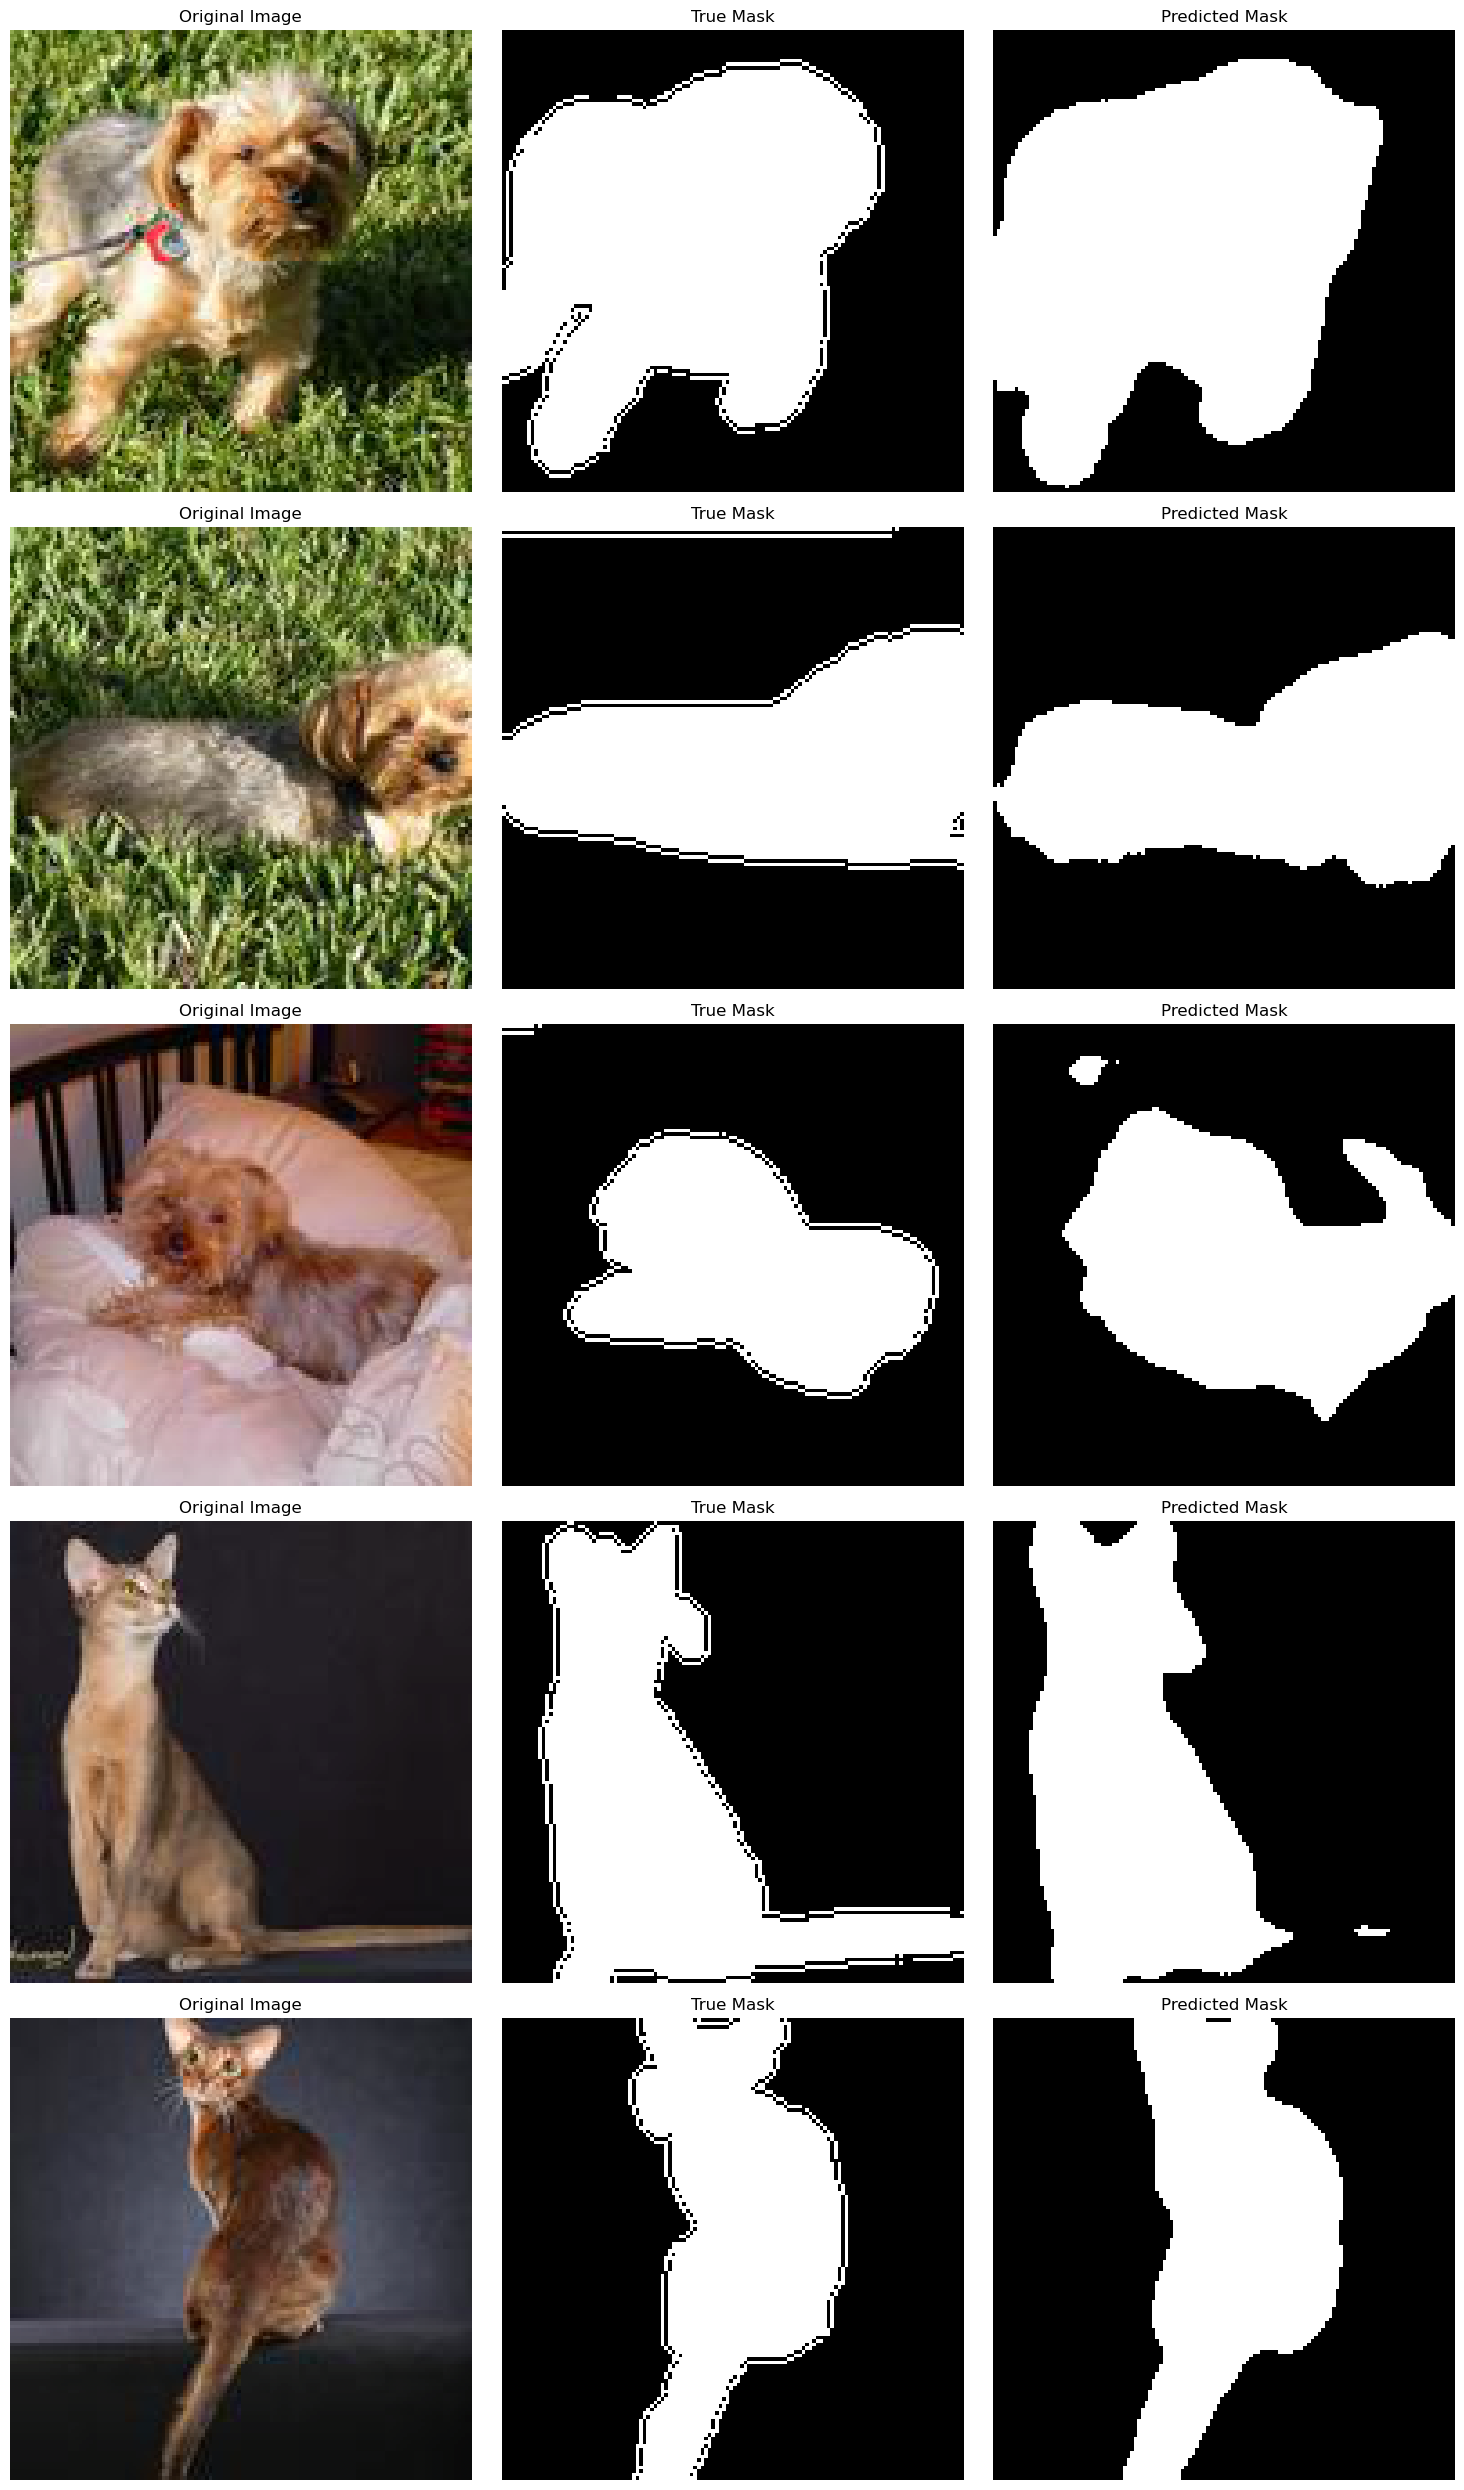

In [13]:
# Load the best model
best_model = load_best_model('best_unet_model.pth')

# Create a validation dataset for testing
test_dir = r'D:\Emma\cv-project\Dataset\consistent_size\test'  # Update this path to your test directory
test_dataset = SegmentationDataset(
    os.path.join(test_dir, 'color'),
    os.path.join(test_dir, 'label')
)

# Calculate metrics on the test dataset
print("\nCalculating metrics on test dataset:")
calculate_metrics(best_model, test_dataset)

# Visualize some predictions
print("\nVisualizing predictions:")
visualize_predictions(best_model, test_dataset, num_samples=5)